# Analyse des utilisateurs

On cherche à analyser les données du fichier train_users_2.csv. 

In [1]:
import pandas as pd
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

On va importer les données, ajouter la variable "destination_found" qui aura pour valeur NDF ("No Destination Found") ou DF (Destination Found) et rééquilibrer les classes NDF et DF en selectionant $n$ données de chaque classe. Ici, $n=88000$. On finit par mélanger les données.

In [2]:
users = pd.read_csv('./data/train_users_2.csv', sep=',')

n = 88000
users['destination_found'] = users.apply(lambda r: 'NDF' if r['country_destination'] == 'NDF' else 'DF', axis=1)
users = pd.concat([users[users['destination_found'] == 'NDF'].head(n), users[users['destination_found'] == 'DF'].head(n)]).sample(frac=1).reset_index(drop=True)

In [3]:
users.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,destination_found
0,sp0x8baacl,2013-09-10,20130910043121,NaN,MALE,26.0,facebook,0,pt,seo,facebook,linked,Web,Android Phone,Chrome Mobile,NDF,NDF
1,80mykivi60,2013-10-04,20131004150539,NaN,-unknown-,NaN,basic,25,en,direct,direct,untracked,iOS,iPhone,-unknown-,NDF,NDF
2,c1vmqstry6,2014-01-04,20140104061630,2014-05-01,FEMALE,32.0,basic,24,en,direct,direct,linked,Moweb,iPad,Mobile Safari,US,DF
3,1uqcfcfo3y,2013-04-03,20130403021800,NaN,MALE,24.0,facebook,0,en,sem-brand,google,omg,Web,Windows Desktop,IE,NDF,NDF
4,bn1ywb7lxo,2011-11-15,20111115060008,NaN,-unknown-,NaN,basic,2,en,direct,direct,untracked,Web,iPhone,-unknown-,NDF,NDF


## Analyse des données générales

In [4]:
# On a 15 variables
users.columns[:15]

Index(['id', 'date_account_created', 'timestamp_first_active',
       'date_first_booking', 'gender', 'age', 'signup_method', 'signup_flow',
       'language', 'affiliate_channel', 'affiliate_provider',
       'first_affiliate_tracked', 'signup_app', 'first_device_type',
       'first_browser'],
      dtype='object')

### Gender

OTHER : 261 représentants


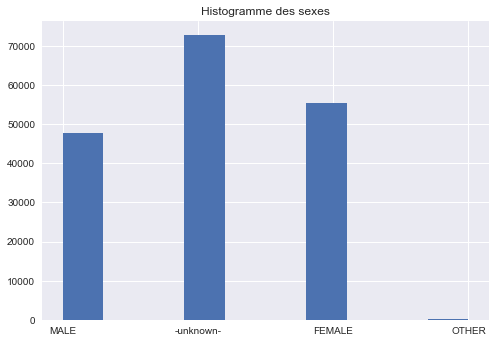

In [5]:
_ = plt.hist(users['gender'])
plt.title("Histogramme des sexes")
print(f"OTHER : {users[users['gender'] == 'OTHER'].shape[0]} représentants")

On distingue 4 valeurs possibles pour "gender" : "MALE", "FEMALE", "-unknown-" et OTHER. La valeur "-unknown-" est majoritairement représentée. On voit qu'il y a un peu plus de femme que d'homme dans ces données. La valeur "OTHER" est sous représentée avec seulement 261 représentants. La pluplart des utilisateurs ne donnent pas d'information concernant leur sexe. Vérifions s'il n'y aurait pas de corrélation avec les variables cibles.

gender             -unknown-  FEMALE   MALE  OTHER
destination_found                                 
DF                     28685   31684  27456    175
NDF                    44101   23629  20184     86


Text(0.5, 1.0, 'Proportion des sexes selon la destination')

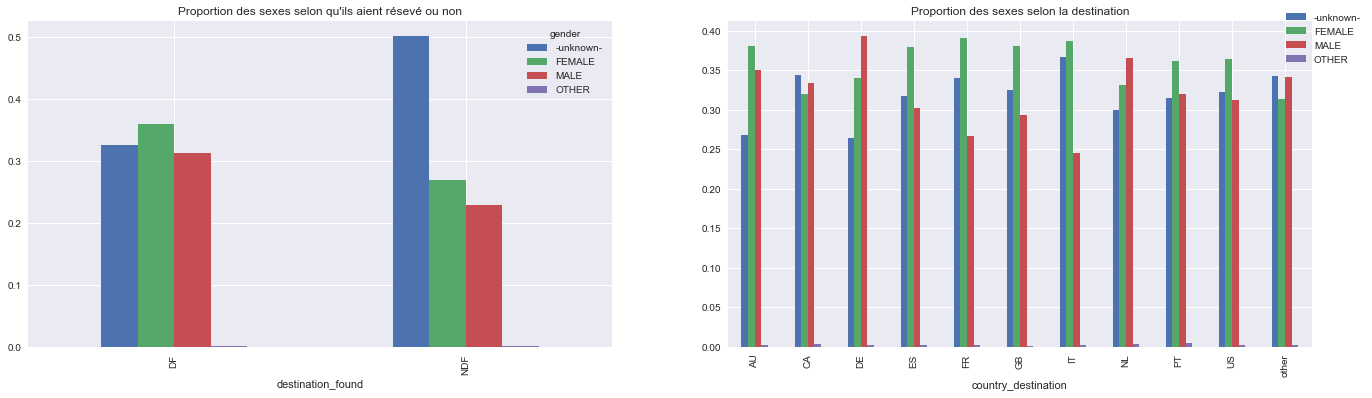

In [6]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(23, 6))
var = pd.crosstab(users['destination_found'], users['gender'])
var.div(var.sum(1).astype(float), axis=0).plot(kind="bar", stacked=False, ax=ax1)
ax1.set_title("Proportion des sexes selon qu'ils aient résevé ou non")
print(var)

df_users = users[users['destination_found'] == 'DF']
var = pd.crosstab(df_users['country_destination'], df_users['gender'])
var.div(var.sum(1).astype(float), axis=0).plot(kind="bar", stacked=False, ax=ax2)
plt.legend(bbox_to_anchor=(1.1, 1.05))
ax2.set_title("Proportion des sexes selon la destination")

On remarque que la valeur "-unknown" est très présente parmi les NDF. Par aiilleurs, les utilisateurs qui ont renseigné leur sexe ont tendence à réserver une destination.

Au niveau de la distribution par pays, on voit que les utilisateurs ayant réservé en Allemagne (DE) et aux Pays-Bas (NL) sont plus généralement des hommes tandis que celles ayant réservé en Italie (IT), France (FR) et Grande-Bretagne (GB) sont plus souvent des femmes. Pour les autres pays, la différence est trop faible pour établir une quelconque conclusion. Souvent, il peut être normalement de voir que le nombre de femmes est légèrement supérieur au nombre d'homme chez certains pays puisque le nombre total de femmes dans ces données supérieur à celui de l'homme.

### Age

0.25    29.0
0.50    34.0
0.75    42.0
Name: age, dtype: float64


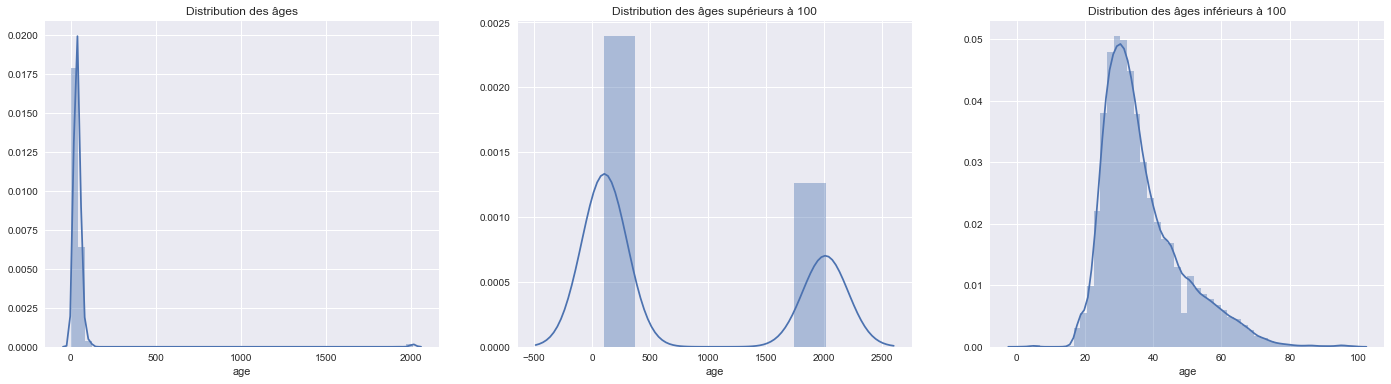

In [7]:
f = plt.figure(figsize=(24, 6))
f.add_subplot(1, 3, 1)
sns.distplot(users['age'])
plt.title("Distribution des âges")

f.add_subplot(1, 3, 2)
sns.distplot(users[users['age'] >= 100]['age'])
plt.title("Distribution des âges supérieurs à 100")

f.add_subplot(1, 3, 3)
sns.distplot(users[users['age'] < 100]['age'])
plt.title("Distribution des âges inférieurs à 100")

print(users[users['age'] < 100]['age'].quantile([0.25, 0.5, 0.75]))

Ici, on voit clairement que l'âge est erroné (certaines personnes auraient plus de 2000 ans). Il est possible que des individus aient renseignés leur années de naissance à la place de leur âge ou ayant sélectionné l'année par défaut (souvent l'année de la création du compte, aux alentours de 2014).
Plusieurs remarques :
* l'âge médian est de 34 ans. 
* un groupe de personnes ont indiqué un âge proche des 2000 ans ; on supposera qu'ils ont confondu l'âge et l'année de naissance.
* un groupe de personnes ont indiqué un âge proche de 2014 ; on supposera qu'ils s'agit de l'année par défaut et (qu'au delà de 2000) ils n'ont donc renseigné aucune valeur.
* un groupe de personnes ont donné un âge qui avoisine des 200 ans.

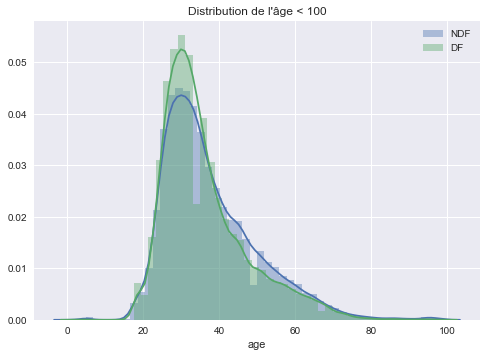

In [8]:
sns.distplot(users[(users['destination_found'] == 'NDF') & (users['age'] < 100)]['age'], label='NDF')
sns.distplot(users[(users['destination_found'] == 'DF') & (users['age'] < 100)]['age'], label='DF')
plt.title("Distribution de l'âge < 100")
plt.legend()

Les individus marqués comme étant DF ont un âge légèrement plus centré vers les 30 ans que ceux marqués comme étant NDF. Ces derniers ont une population qui est légèrement plus importante au niveau des 50 ans. Autrement, peu d'éléments peuvent en être déduites ; les données sur l'âge des types de population sont relativement proches. 

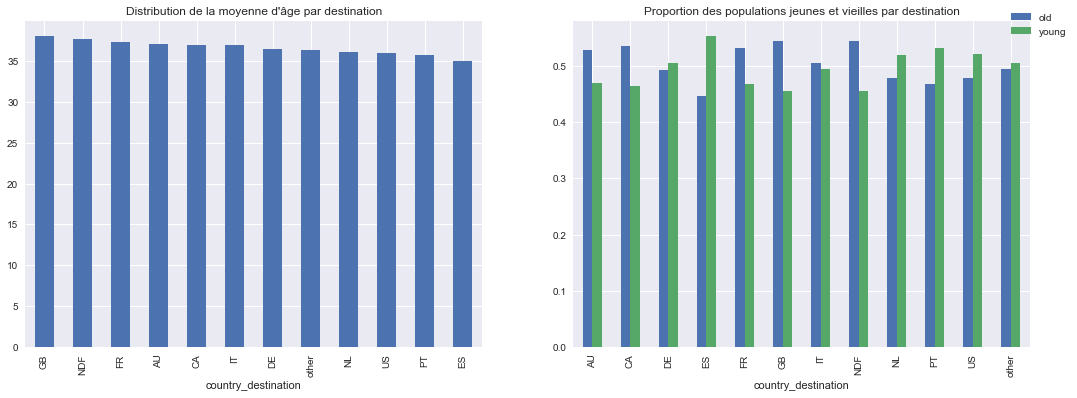

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
destination_ages = users[users['age'] < 100].groupby('country_destination').agg({'age': np.mean})['age'].sort_values(ascending=False)
destination_ages.plot(kind='bar', ax=ax1)
ax1.set_title("Distribution de la moyenne d'âge par destination")

users['age_category'] = users.apply(lambda r: 'young' if r['age'] < 34 else 'old', axis=1)
var = pd.crosstab(users[users['age'] < 100]['country_destination'], users[users['age'] < 100]['age_category'])
var.div(var.sum(1).astype(float), axis=0).plot(kind="bar", stacked=False, ax=ax2)
ax2.set_title("Proportion des populations jeunes et vieilles par destination")
plt.legend(bbox_to_anchor=(1.1, 1.05))
users = users.drop('age_category', axis=1)

On peut voir que les utilisateurs qui ont effectué une réservation en Grande-Bretagne (GB), France (FR), Canada (CA) ou Australie (AU) ont tendance a être plus âgés que le reste. À l'inverse, les utilisateurs ayant réservé en Espagne (ES), Portugal (PT) ou aux Etats-Unis (US) ont tendance à être plus jeune. Les utilisateurs n'ayant fait de réservation tendent à être plus âgé également. Cela rejoint notre observation sous le graphique précédent.

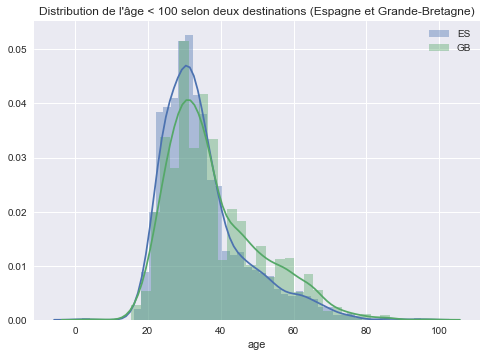

In [10]:
sns.distplot(users[(users['country_destination'] == 'ES') & (users['age'] < 100)]['age'], label='ES')
sns.distplot(users[(users['country_destination'] == 'GB') & (users['age'] < 100)]['age'], label='GB')
plt.title("Distribution de l'âge < 100 selon deux destinations (Espagne et Grande-Bretagne)")
_ = plt.legend()

Cependant, en mettant en contraste les pays extrêmes, on voit que la population des 40 à 70 ans est légèrement plus importante parmi ceux ayant réservé en Grande-Bretagne (GB) qu'en Espagne. Ceux ayant fait une réservation en Espagne ont une population plus importante dans la tranche d'âges [20, 25]. Les tranches d'âges citées ici seront utiles pour catégoriser l'âge des individus. En effet, il serait intéressant de créer des groupes par tranche d'âge ; notament [20, 25] et [40, 70] par exemple afin de mieux séparer nos indvidus.

Néanmoins, les données restent peu séparables dans ce cas.

Etudions les cas où les ages sont erronés. On peut s'attendre à ce qu'il y ait une plus grande proportion de NDF ici, dans l'éventualité qu'un profil incomplet ou erroné un refus de réservation.

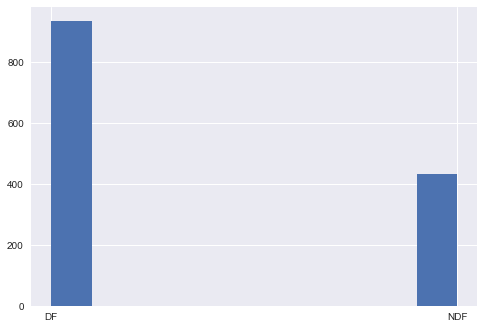

In [11]:
_ = plt.hist(users[(users['age'] > 100) & (users['age'] < 1000)]['destination_found'])

On observe l'effet inserve, à savoir qu'il y a plus de DF que de NDF parmi les utilisateurs avec un âge erroné.

### Signup_method

On va s'intéresser à la manière dont l'utilisateur s'est inscrit / se connecte.

Signup with Google : 98


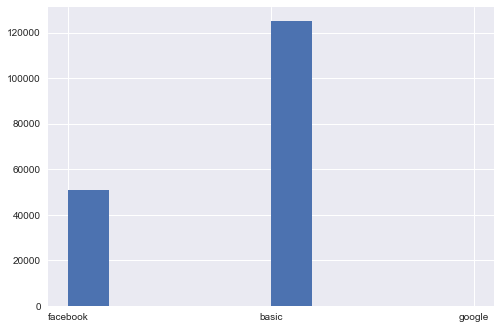

In [12]:
_ = plt.hist(users['signup_method'])
print(f"Signup with Google : {users[users['signup_method'] == 'google'].shape[0]}")

La majorité des utilisateurs se sont inscrits via le site d'Airbnb. Une plus faible partie se connecte depuis Facebook et une minorité depuis Google. Ces derniers sont constitués que de 98 utilisateurs, ce qui est très faible comparé aux 176000 utilisateurs étudiés.

signup_method      basic  facebook  google
destination_found                         
DF                 64362     23540      98
NDF                60672     27328       0


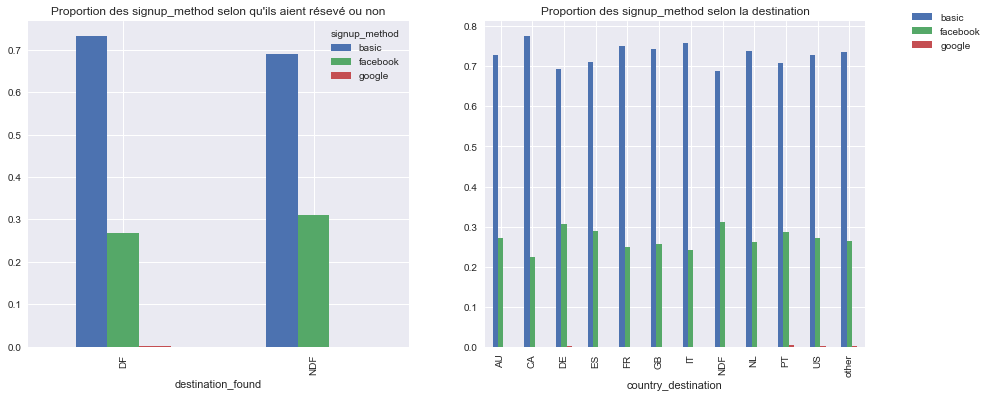

In [13]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
var = pd.crosstab(users['destination_found'], users['signup_method'])
var.div(var.sum(1).astype(float), axis=0).plot(kind="bar", stacked=False, ax=ax1)
ax1.set_title("Proportion des signup_method selon qu'ils aient résevé ou non")
print(var)

var = pd.crosstab(users['country_destination'], users['signup_method'])
var.div(var.sum(1).astype(float), axis=0).plot(kind="bar", stacked=False, ax=ax2)
plt.legend(bbox_to_anchor=(1.1, 1.05))
_ = ax2.set_title("Proportion des signup_method selon la destination")

On peut distinguer une légère tendence à s'incrire directement depuis le site d'Airbnb ou Google parmi les DF alors que les NDF ont une tendance pour Facebook.
Soulignons que 100% des utlisateurs inscrit à partir de Google sont des DF.

### Signup_flow

Il s'agit du numéro de la page à partir duquel l'utilisateur à décider de s'inscrire.

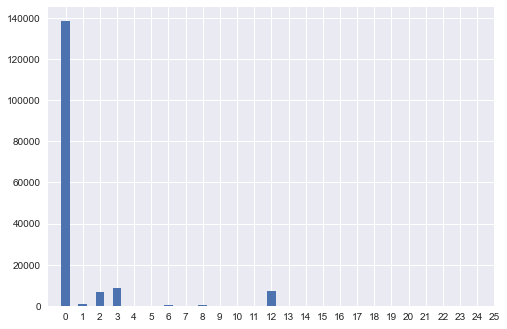

In [14]:
_ = plt.hist(users['signup_flow'], bins=np.arange(users['signup_flow'].nunique())-0.5, rwidth=0.5)
_ = plt.xticks(range(0, 26))

On voit que la grande majorité des individus se sont inscrits dès la page 0 (page d'accueil). Les autres pages les plus fréquentes sont les pages 2, 3 et 12. Il est probable que l'utilisateur ait trouvé un logement intéressant et a donc décidé de s'inscrire à cet instant. Néanmoins, ce pic à la page 12 reste assez étrange. Il est possible qu'il s'agisse de la dernière page de recherche dans la majorité des cas. Les pages suivantes n'existeraient que dans quelques rares destinations. Ceux ayant atteints la page 12 n'ont peut être pas l'intention de trouver un logement mais seulement regarder ce qui est proposé.

Affichons les histogrammes par classes et destinations afin de vérifier l'hypothèse. La valeur 0 du signup_flow a été volontairement retirée dans le graphique de droite car les proportions étaient très similiares d'une destination à l'autre et également très importante ce qui réduisait la visibilité des autre valeurs du signup_flow.

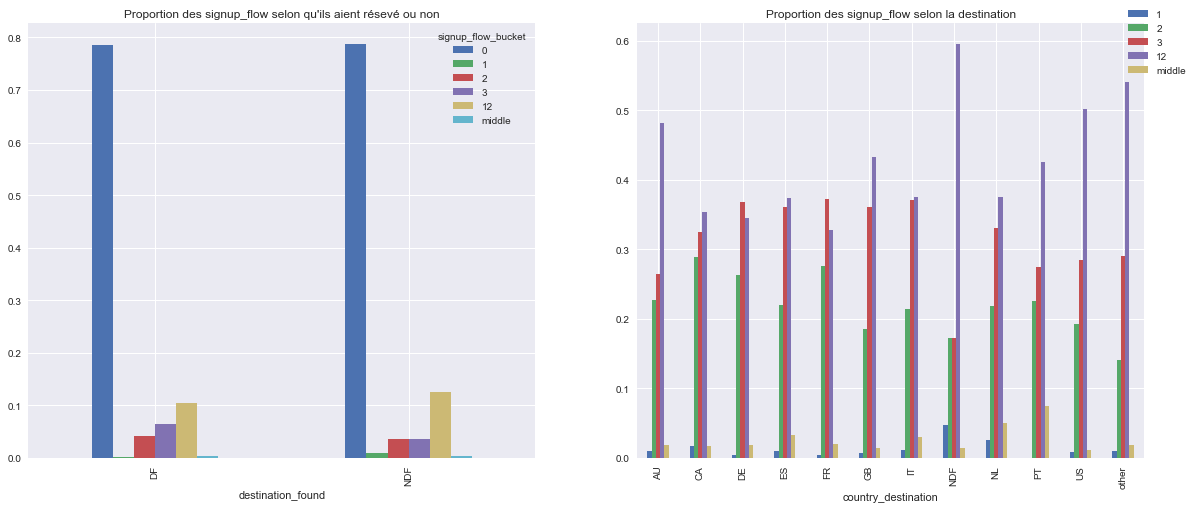

In [15]:
def process_signup_flow(num_page):
    if num_page <= 3:
        return num_page
    elif 3 < num_page < 12:
        return 'middle'
    else:
        return 12
users['signup_flow_bucket'] = users.apply(lambda r: process_signup_flow(r['signup_flow']), axis=1)


fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
var = pd.crosstab(users['destination_found'], users['signup_flow_bucket'])
var.div(var.sum(1).astype(float), axis=0).plot(kind="bar", stacked=False, ax=ax1)
ax1.set_title("Proportion des signup_flow selon qu'ils aient résevé ou non")

var = pd.crosstab(users[users['signup_flow_bucket'] != 0]['country_destination'], users[users['signup_flow_bucket'] != 0]['signup_flow_bucket'])
var.div(var.sum(1).astype(float), axis=0).plot(kind="bar", stacked=False, ax=ax2)
plt.legend(bbox_to_anchor=(1.1, 1.05))
_ = ax2.set_title("Proportion des signup_flow selon la destination")
users = users.drop('signup_flow_bucket', axis=1)

On voit bien que ceux qui se sont inscrit dés la 2e ou 3e page ont tendance à effectuer une réservation tandis que ceux qui ont atteint la page 12 (voir les pages supérieures) ont tendance à ne pas réserver ce qui valide notre hypothèse précédente. Pour les autres pages, les proportions semblent identiques d'une classe à l'autre.

Au niveau des différentes destinations :
* la proportion des personnes ayant atteint la page 12 est plus forte pour ceux qui réservent au Etats-Unis (US), Australie (AU), Grande-Bretagne (GB), Portugal (PT) et les autres pays non recensés (other).
* ceux des pages 4 à 11 (middle) ont tendance à réserver au Portugal (PT), Espagne (ES) et aux Pays-Bas (NL).
* ceux de la page 2 ont tendance à réserver au Canada (CA) ou en France (FR) mais peu en Grande-Bretagne (GB) et dans les autres pays non recensés (other).
* ceux de la page 3 apparaissent souvent pour les classe (CA), (DE), (ES), (GB), (IT), (NL) mais peu pour les autres classes. On obtient ainsi deux groupes.

### Language

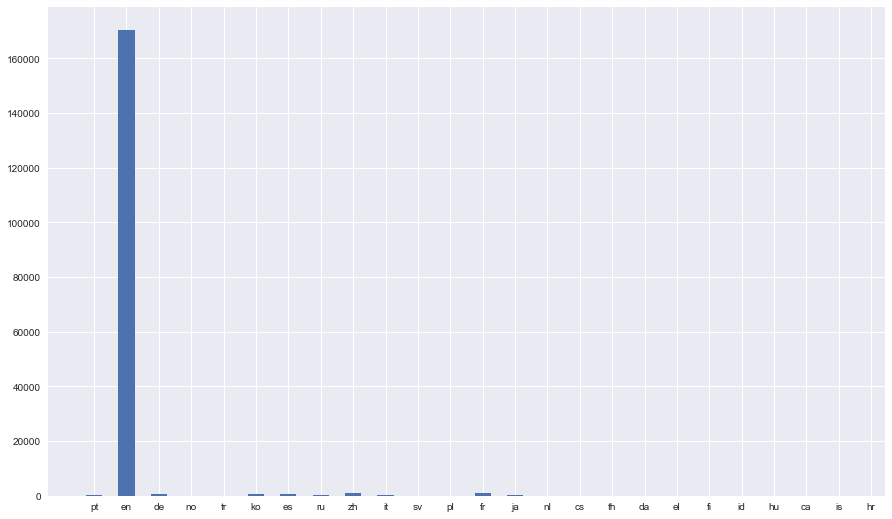

In [16]:
plt.figure(figsize=(15, 9))
_ = plt.hist(users['language'], bins=np.arange(users['language'].nunique())-0.5, rwidth=0.5)

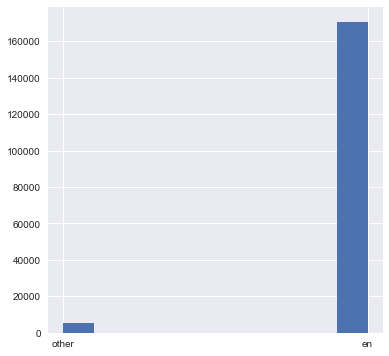

In [17]:
users['language_group'] = users.apply(lambda r: 'en' if r['language'] == 'en' else 'other', axis=1)
plt.figure(figsize=(6, 6))
_ = plt.hist(users['language_group'])
users = users.drop('language_group', axis=1)

La langue majoritairement détectée est l'anglais (en) ce qui est attendu puisque les utilisateurs proviennent des Etats-Unis. Le reste des langues est très faiblement représenté.

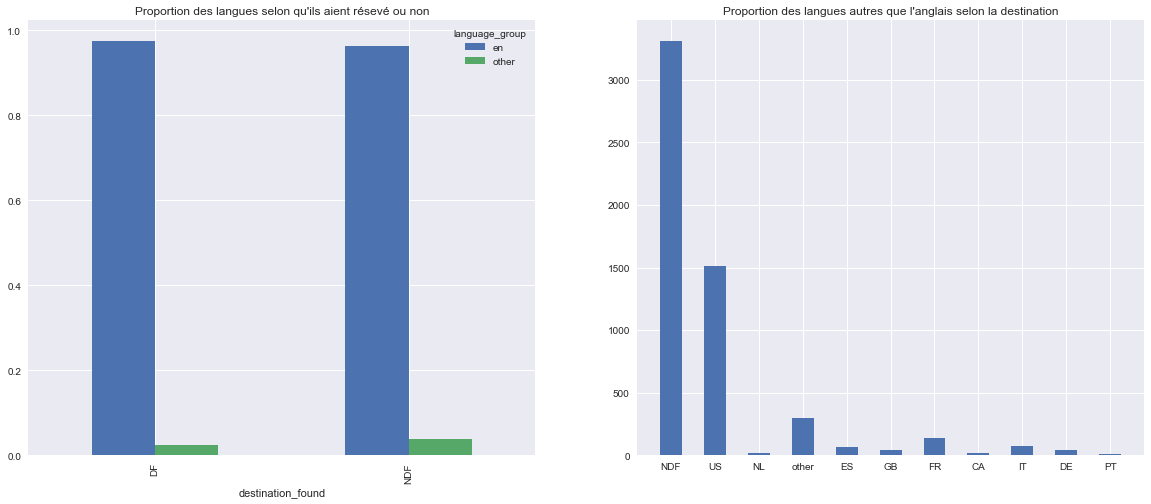

In [18]:
users['language_group'] = users.apply(lambda r: 'en' if r['language'] == 'en' else 'other', axis=1)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
var = pd.crosstab(users['destination_found'], users['language_group'])
var.div(var.sum(1).astype(float), axis=0).plot(kind="bar", stacked=False, ax=ax1)
ax1.set_title("Proportion des langues selon qu'ils aient résevé ou non")

plt.hist(users[users['language_group'] == 'other']['country_destination'], bins=np.arange(users['country_destination'].nunique())-0.5, rwidth=0.5)
_ = ax2.set_title("Proportion des langues autres que l'anglais selon la destination")
users = users.drop('language_group', axis=1)

On voit que ceux employant une autre langue que l'anglais ont une légère tendance à ne pas réserver. Parmi ces derniers, ceux qui effectue tout de même une réservation se tourne majoritairement vers les Etats-Unis (US). On distingue également une proportion plus élevée que les autres parmi ceux réservant en France (FR) ou dans les pays non recensés (other).

Affichons les différents languages par pays (sans compter l'anglais).

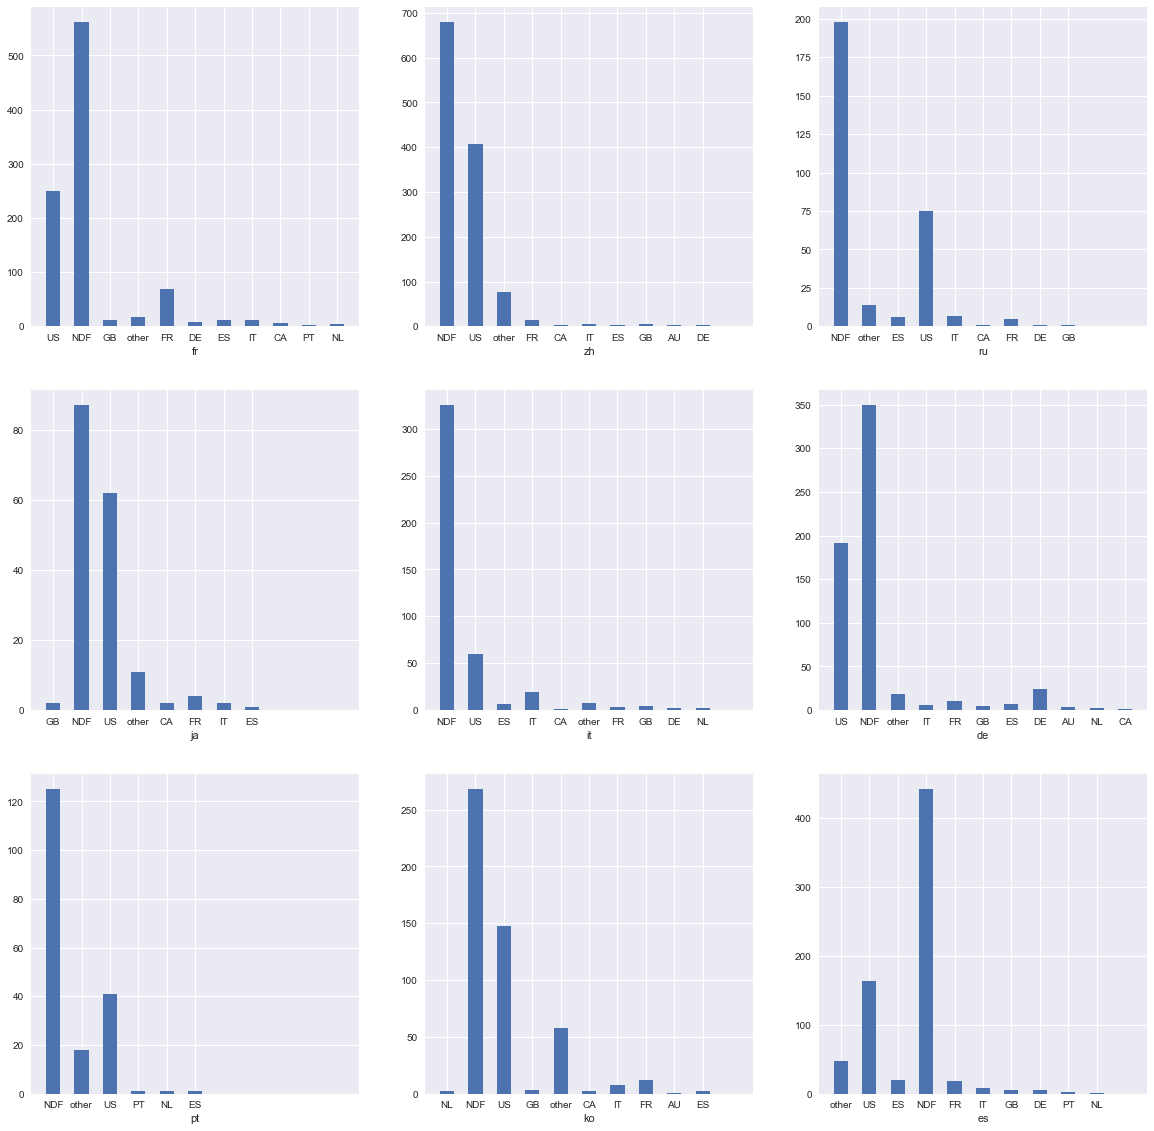

In [19]:
languages = ['fr', 'zh', 'ru', 'ja', 'it', 'de', 'pt', 'ko', 'es']
f = plt.figure(figsize=(20, 20))
for i, language in enumerate(languages):
    f.add_subplot(3, 3, i+1)
    plt.hist(users[users['language'] == language]['country_destination'], bins=np.arange(users['country_destination'].nunique())-0.5, rwidth=0.5)
    plt.xlabel(language)

On voit que :
* pour chaque langage, la classe NDF est majoritaire suivie des Etats-Unis (US).
* la troisième destination est très souvent le pays où le langage en est la langue maternelle (par exemple, une partie de ceux qui employe le français réverse en France). Le Portugal et l'Espagne semblent y faire exception. En effet, la classe "other" y prend la 3e position des destinations les plus réservées par ces derniers. Cela n'est pas étrange si on pense aux autres pays de langue portugaise ou espagnol comme le Brésil et le Chili qui ne figurent pas directement parmi les destinations mais rentrent dans la catégorie "other".

### Affiliate_channel

On va étudier la méthode/le canal utilisé pour la campagne d'affiliation par laquel l'utilisateur est arrivé. Cette variable ne concerne pas les informations propres des utilisateurs mais pluôt le processus de marketing employé par Airbnb.

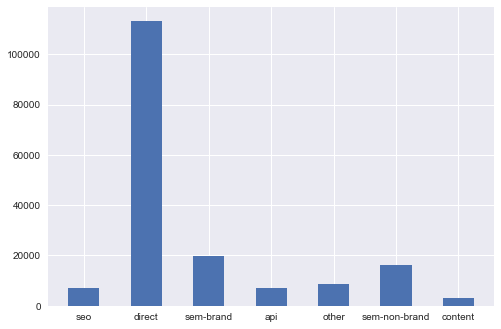

In [20]:
_ = plt.hist(users['affiliate_channel'], bins=np.arange(users['affiliate_channel'].nunique())-0.5, rwidth=0.5)

La plupart du temps, les utlisateurs viennent directement sur le site d'Airbnb sans l'aide d'une quelconque campagne d'affiliation (valeur "direct") comme le montre l'histogramme. 

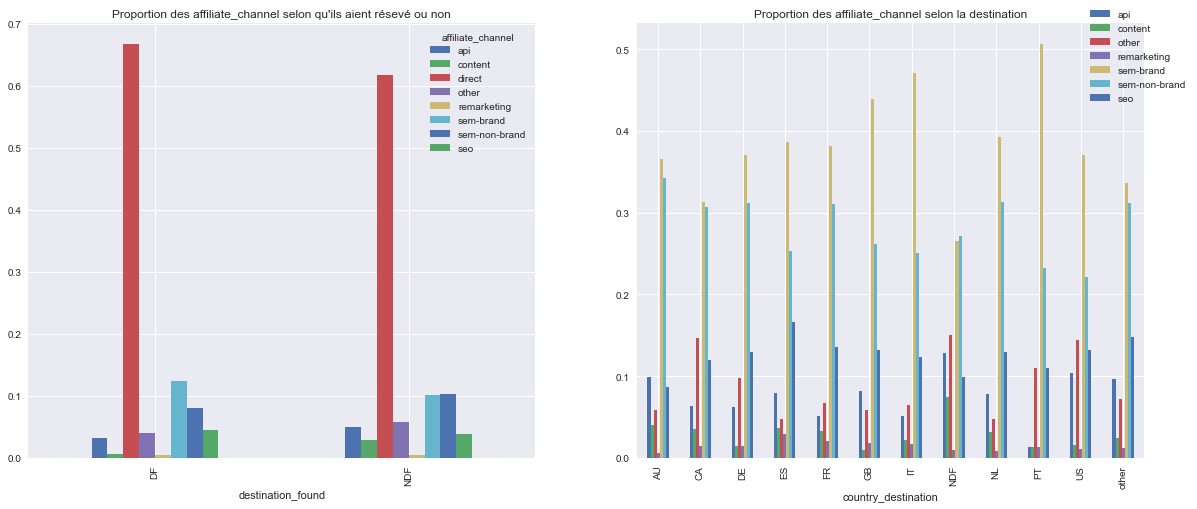

In [21]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
var = pd.crosstab(users['destination_found'], users['affiliate_channel'])
var.div(var.sum(1).astype(float), axis=0).plot(kind="bar", stacked=False, ax=ax1)
ax1.set_title("Proportion des affiliate_channel selon qu'ils aient résevé ou non")

var = pd.crosstab(users[users['affiliate_channel'] != 'direct']['country_destination'], users[users['affiliate_channel'] != 'direct']['affiliate_channel'])
var.div(var.sum(1).astype(float), axis=0).plot(kind="bar", stacked=False, ax=ax2)
plt.legend(bbox_to_anchor=(1.1, 1.05))
_ = ax2.set_title("Proportion des affiliate_channel selon la destination")

On voit que la valeur "direct" est légèrement plus importante parmi les DF que les NDF. Il est possible que les utilisateurs se rendant directement sur le site ont une idée de destination en tête ou l'envie de voyager ce qui augmente la tentation de réserver.
La valeur "sem_brand" est un peu plus présente chez les DF. En revanche, la valeur "sem_non_brand", "content" et "api" sont plus représentées du côté des NDF. 

Du côté des destinations, la valeur "direct" prend trop d'importance sans pour autant permettre de discriminer les données et a donc été filtrée.

Au final, peu d'information pertinente ont pu être tirées de cette variable.

### Affiliate_provider

On va s'intéresser aux sites et plateformes affiliés à partir duquel l'utilisateur est venu. Cette variable contient beaucoup de valeurs ce qui nuit à la visualisation des données. On va donc regrouper les valuers les moins présentes ensemble en une valuer nommée "exit_group".

In [22]:
providers = users.groupby('affiliate_provider').count()[['id']].rename({'id': 'count'})
providers = providers[providers['id'] > 1000]
provider_names = set(providers.index)

users['affiliate_provider_processed'] = users.apply(lambda r: r['affiliate_provider'] if r['affiliate_provider'] in provider_names else 'exit_group', axis=1)

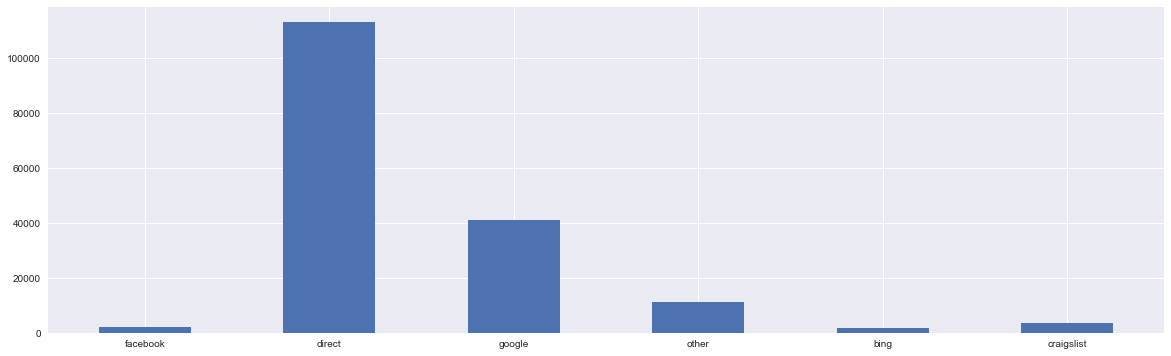

In [23]:
plt.figure(figsize=(20, 6))
_ = plt.hist(users['affiliate_provider_processed'], bins=np.arange(users['affiliate_provider_processed'].nunique())-0.5, rwidth=0.5)

On observe que la plupart des utilisateurs provenant d'un site affilié (hors valeur "direct") viennent d'une annonce depuis "google".

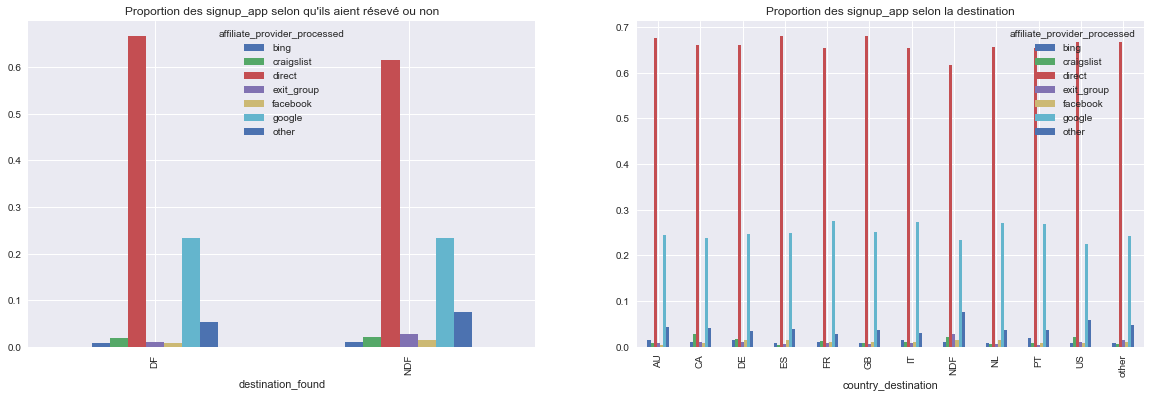

In [24]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
var = pd.crosstab(users['destination_found'], users['affiliate_provider_processed'])
var.div(var.sum(1).astype(float), axis=0).plot(kind="bar", stacked=False, ax=ax1)
ax1.set_title("Proportion des signup_app selon qu'ils aient résevé ou non")

var = pd.crosstab(users['country_destination'], users['affiliate_provider_processed'])
var.div(var.sum(1).astype(float), axis=0).plot(kind="bar", stacked=False, ax=ax2)
_ = ax2.set_title("Proportion des signup_app selon la destination")

On remarque que les utilisateurs qui ne réservent pas (NDF) et qui viennet d'un site affilié ont une plus grande tendance à provenir de plateformes diverse et peu connues que les Df comme le montre le pourcentage plus élevé de "exit_group" et "other" parmi les NDF. 

Peu de conclusions peuvent être déduite de cette variable au sujet des différentes destinations.

### First affiliate tracked

On va s'intéresser à la première affiliation qui est entrée en intéraction avec l'utilisateur avant son inscription sur la plateforme d'Airbnb. Cette variable contient de valeurs NaN à filtrer avant analyse (voir le notebook introductif).

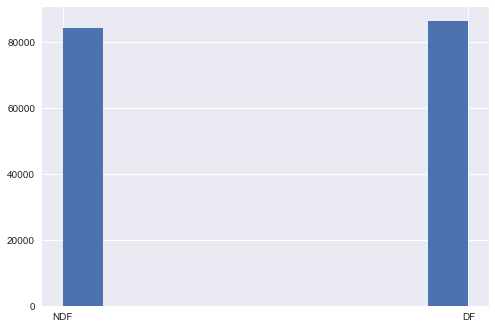

In [41]:
aff_tracked_users = users[~users['first_affiliate_tracked'].isnull()]
aff_tracked_users['destination_found'].hist()

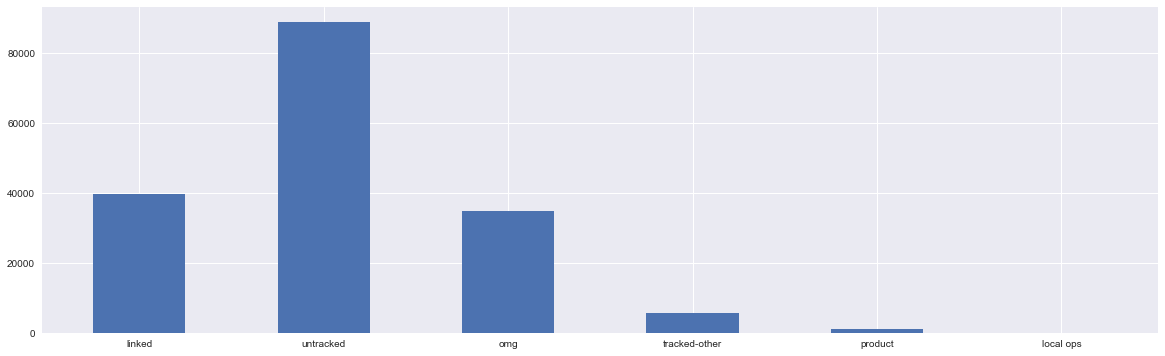

In [37]:
plt.figure(figsize=(20, 6))
_ = plt.hist(aff_tracked_users['first_affiliate_tracked'], bins=np.arange(aff_tracked_users['first_affiliate_tracked'].nunique())-0.5, rwidth=0.5)

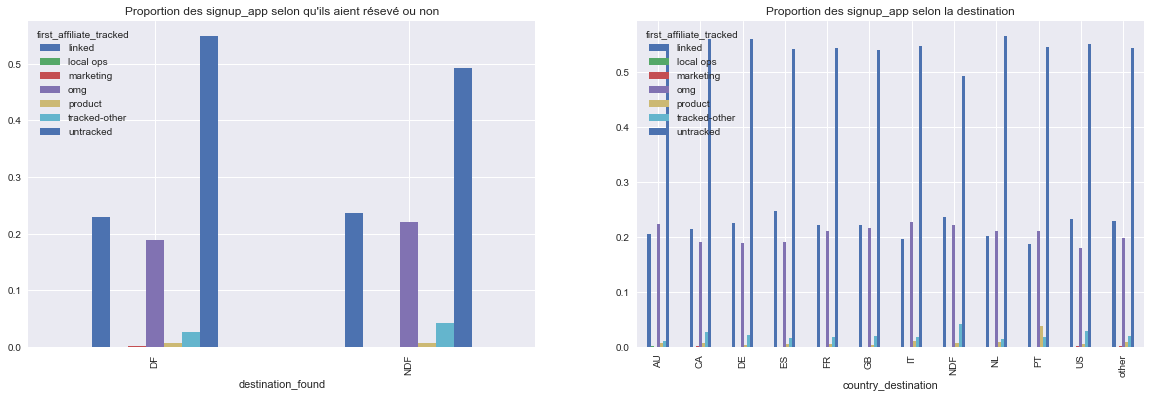

In [40]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
var = pd.crosstab(aff_tracked_users['destination_found'], aff_tracked_users['first_affiliate_tracked'])
var.div(var.sum(1).astype(float), axis=0).plot(kind="bar", stacked=False, ax=ax1)
ax1.set_title("Proportion des signup_app selon qu'ils aient résevé ou non")

var = pd.crosstab(aff_tracked_users['country_destination'], aff_tracked_users['first_affiliate_tracked'])
var.div(var.sum(1).astype(float), axis=0).plot(kind="bar", stacked=False, ax=ax2)
_ = ax2.set_title("Proportion des signup_app selon la destination")

On peut voir que la valeur "product" apparait plus souvent chez les individus qui réservent au Portugal (PT) par rapport aux autres destinations. 

Très peu d'information peuvent être déduite de cette variable. Les proportions sont quasi-identiques d'une classe à l'autre.

### Signup_app

In [ ]:
_ = plt.hist(users['signup_app'])

On voit que peu d'individus se sont inscrits depuis un appareil iOS, mobile ou Android. En effet, une forte majorité passe par l'application web marqué sous la valeur "Web". Cela ne semble pas étrange étant donné qu'il était peut être plus difficile d'effectuer des payements et recherche via un smartphone avant 2014. 

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(20, 13))
var = pd.crosstab(users['destination_found'], users['signup_app'])
var.div(var.sum(1).astype(float), axis=0).plot(kind="bar", stacked=False, ax=ax1)
ax1.set_title("Proportion des signup_app selon qu'ils aient résevé ou non")

var = pd.crosstab(users['country_destination'], users['signup_app'])
var.div(var.sum(1).astype(float), axis=0).plot(kind="bar", stacked=False, ax=ax2)
_ = ax2.set_title("Proportion des signup_app selon la destination")


noweb_users = users[users['signup_app'] != 'Web']
var = pd.crosstab(noweb_users['destination_found'], noweb_users['signup_app'])
var.div(var.sum(1).astype(float), axis=0).plot(kind="bar", stacked=False, ax=ax3)
_ = ax3.set_title("Proportion des signup_app selon la destination sans la valeur Web")


var = pd.crosstab(noweb_users['country_destination'], noweb_users['signup_app'])
var.div(var.sum(1).astype(float), axis=0).plot(kind="bar", stacked=False, ax=ax4)
plt.legend(bbox_to_anchor=(1.1, 1.05))
_ = ax4.set_title("Proportion des signup_app selon la destination sans la valeur Web")

On voit une plus grande utilisation de l'application Android du côté des NDF que du côté des DF. À l'inverse, on observe une très légère tendance pour l'utilisation de l'application iOS du côté des DF.

Dans chaque destination, l'application Web est la plus utilisée suivis de l'application iOS. 

### First_device_type

In [ ]:
plt.figure(figsize=(20, 6))
_ = plt.hist(users['first_device_type'], bins=np.arange(users['first_device_type'].nunique()+1)-0.5, rwidth=0.5, density=True)

Près de la moitié des utilisateurs se sont connectés depuis un "Mac desktop" en prelier lieu. Un tier utilise "Windows Desktop". L'utilisation de tablets et smartphone est très faible par rapport à l'utilisation d'un ordinateur. Cela rejoint l'hypothèse qu'il serait plus simple d'utiliser un ordinateur qu'un téléphone pour réserver ou effectuer des recherches. 

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
var = pd.crosstab(users['destination_found'], users['first_device_type'])
var.div(var.sum(1).astype(float), axis=0).plot(kind="bar", stacked=False, ax=ax1)
ax1.set_title("Proportion des first_device_type selon qu'ils aient résevé ou non")

var = pd.crosstab(users['country_destination'], users['first_device_type'])
var.div(var.sum(1).astype(float), axis=0).plot(kind="bar", stacked=False, ax=ax2)
_ = ax2.set_title("Proportion des first_device_type selon la destination")

On distingue une plus grande proportion de NDF parmi ceux marqués comme "Other/Unknown" pour la variable "first_device_type". La proportion de "Mac Desktop" est plus importante du côté des DF. Chaque destination suit plus ou moins les mêmes proportions pour chaque valeur à l'exception des Etats-Unis (US) où on rencrontre plus d'utilisateur d'iPhone que d'iPad. 

### First_browser

Cette variable possède beaucoup de valeurs dont la plupart sont très peu répendues. On peut donc, pour simplifier l'affichage graphique, regrouper ces éléments ensemble. avant d'affichier un graphique.

In [ ]:
users.groupby('first_browser').count()[['id']].sort_values(by='id').head(10)

In [ ]:
users_browsers = users.groupby('first_browser').count()[['id']].sort_values(by='id')
browsers = set(users_browsers[users_browsers['id'] > 1000].index)
users['first_browsers_processed'] = users.apply(lambda r: r['first_browser'] if r['first_browser'] in browsers else 'Other', axis=1)

plt.figure(figsize=(20, 6))
_ = plt.hist(users['first_browsers_processed'], bins=np.arange(users['first_browsers_processed'].nunique()+1)-0.5, rwidth=0.5, density=True)

On voit qu'une majorité utilise Chrome suivi de Safari puis de Firefox. 

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
var = pd.crosstab(users['destination_found'], users['first_browsers_processed'])
var.div(var.sum(1).astype(float), axis=0).plot(kind="bar", stacked=False, ax=ax1)
ax1.set_title("Proportion des first_device_type selon qu'ils aient résevé ou non")

var = pd.crosstab(users['country_destination'], users['first_browsers_processed'])
var.div(var.sum(1).astype(float), axis=0).plot(kind="bar", stacked=False, ax=ax2)
_ = ax2.set_title("Proportion des first_device_type selon la destination")

On distingue une plus grande proportion de "-unknown-" et d'Internet Explorer (IE) chez les NDF mais une plus grande poportion de Chrome chez les DF.

Les différentes valeurs sont plus ou moins présentes dans les mêmes proportions pour chaque destination.

## Analyse des données liées au temps